# Notebook for looking at photon yield / percentage for diff theta, phi

In [202]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
import sympy
from IPython.display import clear_output
import math
import time

In [183]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/variation/full_{particle}_{energy}GeV_10k.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_14/variation/full_{particle}_{energy}GeV_1000.edm4hep.root:events"
events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
MC_parents = events["_MCParticles_parents.index"].array(library='np')
MC_daughters = events["MCParticles.daughters_end"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

MC_px = events["MCParticles.momentum.x"].array(library='np')
MC_py = events["MCParticles.momentum.y"].array(library='np')
MC_pz = events["MCParticles.momentum.z"].array(library='np')
MC_m = events["MCParticles.mass"].array(library='np')

Idea: first find which super layer, then from there test if in first or second layer

In [205]:
begin = (1830.8 + 1841.4) / 2
super_layer_map_calc = np.empty(14)
layer_map_calc = np.empty(28)
for i in range(14):
    super_layer_map_calc[i] = begin + 76.7 * i
for i in range(28):
    layer_map_calc[i] = (super_layer_map_calc[i // 2] + (i % 2) * 10.6 ) - (10.6 / 2)

dis_between_super_layers = super_layer_map_calc[1] - super_layer_map_calc[0]
dis_between_internal_layers = layer_map_calc[1] - layer_map_calc[0]

def get_super_layer(x_pos):
    rel_dist = x_pos - (super_layer_map_calc[0] - (dis_between_super_layers / 2))
    if(rel_dist < -2):
        return -1
    return int(np.floor(rel_dist / (dis_between_super_layers)))
def get_internal_layer(x_pos,super_layer_idx):
    rel_dist = x_pos - super_layer_map_calc[super_layer_idx]
    return int((math.copysign(1,rel_dist) + 1) /2)
def get_layer(x_pos):
    super_layer_idx = get_super_layer(x_pos)
    internal_layer_idx = get_internal_layer(x_pos,super_layer_idx)
    return int(super_layer_idx * 2 + internal_layer_idx)

In [206]:
start_loop = time.time()
for event_idx in range(len(x_pos_branch)):
    for hit_idx in range(len(x_pos_branch[event_idx])):
        hit_pos = x_pos_branch[event_idx][hit_idx]
        loop_layer = get_num_layers_traversed(hit_pos)
end_loop = time.time()

In [207]:
start_calc = time.time()
for event_idx in range(len(x_pos_branch)):
    for hit_idx in range(len(x_pos_branch[event_idx])):
        hit_pos = x_pos_branch[event_idx][hit_idx]
        loop_layer = get_layer(hit_pos)
end_calc = time.time()

In [208]:
print(f"calc time: {end_calc - start_calc} | loop time: {end_loop - start_loop}")

calc time: 2.8250186443328857 | loop time: 6.0730671882629395


In [136]:
def get_num_layers_traversed(x_pos):
    #This map contains the midpoints of each layer - each layer is 1cm in width, so we can check the 0.5cm on each side to see if a hit was in the layer
    layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]
    for layer_idx in range(len(layer_map)):
        #check if particle hit within layer
        if ((x_pos >= layer_map[layer_idx] - 5) and (x_pos <= layer_map[layer_idx] + 5)):
            return layer_idx
    #if no layers hit, send error code
    return -1
#theta = 0: px, py = 0
#theta - xz plane
#phi - xy plane
#https://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion
def theta_func(px,py,pz):
    return sympy.acos(pz / np.sqrt(px ** 2 + py ** 2 + pz ** 2)) * 180 / np.pi
def phi_func(px,py,pz):
    return sympy.atan2(py,px) * 180 / np.pi


def Efunc(px,py,pz,m):
    return np.sqrt(px**2 + py**2 + pz**2 + m**2)
    
class PVect:
    def __init__(self):
        self.px = 0
        self.py = 0
        self.pz = 0
        self.theta = 0
        self.phi = 0
        self.E = 0
        self.M = 0
    def setVector(self,px,py,pz,m):
        self.px = px
        self.py = py
        self.pz = pz
        self.M = m
        self.E = Efunc(px,py,pz,m)
        self.theta = theta_func(px,py,pz)
        self.phi = phi_func(px,py,pz)

In [ ]:
theta_min = 67
theta_max = 113
phi_min = -22
phi_max = 22

num_MC = 0
num_hits = 0
energy_dep = 0
dep_count = 0
hits_per_photon = []
num_events = len(EDep_branch)
for event_idx in range(len(EDep_branch)):
    if(event_idx > 100):
        break
    num_MC = 0
    primary = PVect()
    primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
    print(f"event # {event_idx}: theta = {primary.theta}; phi = {primary.phi}")

In [8]:
num_MC = 0
num_hits = 0
energy_dep = 0
dep_count = 0
hits_per_photon = []
num_events = len(EDep_branch)
for event_idx in range(len(EDep_branch)):
  
    num_MC = 0
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):num_MC+= 1
    if(num_MC == 0):
        print(f"skipping event #{event_idx}, no optph found")
    else:
        hits_per_photon.append(len(EDep_branch[event_idx]) / num_MC)
#     if(not (event_idx % 100)):
#         print(f"{event_idx // 100} % done")
print(f"% of photons hitting = {sum(hits_per_photon) / len(hits_per_photon) * 100}%")

% of photons hitting = 0.8661019396447213%


# Calculate % of photons hitting sensor for diff theta phi bins

In [191]:
n_bins = 20

theta_min = 68
theta_max = 112
phi_min = -22
phi_max = 22

theta_range = theta_max - theta_min
phi_range = phi_max - phi_min

phi_bins = np.linspace(phi_min,phi_max,n_bins+1)
theta_bins = np.linspace(theta_min,theta_max,n_bins+1)

In [192]:
#works only for evenly spaced bins
def findBin(val,bins):
    diff = bins[1] - bins[0]
    rel_dist = val - bins[0]
    mod = np.floor(rel_dist / diff)
    return int(mod)

In [193]:
theta_percent = [[] for i in range(n_bins)]
phi_percent = [[] for i in range(n_bins)]

theta_MC = np.zeros(n_bins)
phi_MC = np.zeros(n_bins)

theta_hits = np.zeros(n_bins)
phi_hits = np.zeros(n_bins)

theta_counts = np.zeros(n_bins)
phi_counts = np.zeros(n_bins)

num_MC = 0
num_hits = 0
energy_dep = 0
dep_count = 0
hits_per_photon = []
num_events = len(EDep_branch)
break_val = 10000
for event_idx in range(len(EDep_branch)):
    if(not (event_idx % (break_val // 100))):
        clear_output(wait = True)
        print(f"{event_idx // (break_val // 100)}% done")
#     if(event_idx > break_val):
#         break
    num_MC = 0
    primary = PVect()
    primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
    phi_bin = findBin(primary.phi,phi_bins)
    theta_bin = findBin(primary.theta,theta_bins)
    phi_counts[phi_bin]+=1
    theta_counts[theta_bin]+=1
#     print(f"theta, phi: {primary.theta}, {primary.phi} | px,pz = {primary.px,primary.pz} | theta, phi bins: {theta_bin},{phi_bin}")
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22 and (i < MC_daughters[event_idx][0])):
            theta_MC[theta_bin] += 1
            phi_MC[phi_bin] += 1
    for hit in range(len(EDep_branch[event_idx])):
        #check if hit is from optph
        if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] == -22):
            theta_hits[theta_bin] += 1
            phi_hits[phi_bin] += 1
for i in range(n_bins):
    #if no MCParticles, then just set to -1
    if(not len(theta_MC)):
        theta_percent[i] = -1
    else:
        theta_percent[i] = (theta_hits[i] / theta_MC[i]) * 100
    if(not len(phi_MC)):
        phi_percent[i] = -1
    else:
        phi_percent[i] = (phi_hits[i] / phi_MC[i]) * 100

99% done


In [194]:
theta_bin_centers = np.empty(n_bins)
phi_bin_centers = np.empty(n_bins)
for i in range(len(theta_bins) - 1):
    theta_bin_centers[i] = (theta_bins[i] + theta_bins[i+1]) / 2
    phi_bin_centers[i] = (phi_bins[i] + phi_bins[i+1]) / 2

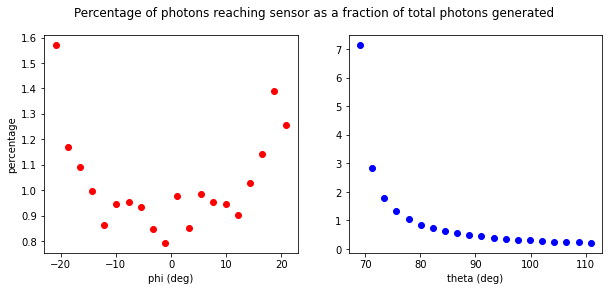

In [195]:
fig, (ax1,ax2) = plot.subplots(1,2, figsize=(10,4))
fig.suptitle("Percentage of photons reaching sensor as a fraction of total photons generated")
ax1.scatter(phi_bin_centers,phi_percent,color="red")
ax1.set_xlabel("phi (deg)")
ax1.set_ylabel("percentage")
ax2.scatter(theta_bin_centers,theta_percent,color = "blue")
ax2.set_xlabel("theta (deg)")
fig.show()
fig.savefig("plots/percentage/June_14_mu_5GeV_10k_phi_theta_20_bins.jpeg")

# OLD EXTRA

In [ ]:
print("theta:           phi: ")
for i in range(n_bins):
    print(f"bin #{i}: {theta_counts[i]}    |   {phi_counts[i]}")

print("theta:           phi: ")
for i in range(n_bins):
    print("bin #%d: %3.2f%%    |    %3.2f%%"%(i,phi_percent[i][0] * 100, theta_percent[i][0] * 100))

In [139]:
momenta = [[ 0.888, -0.296, -0.352],
[0.963,  0.268, -0.025],
[0.992,  0.066, -0.106],
 [0.966, -0.241,  0.094]]

In [140]:
for i in range(len(momenta)):
    print(f"theta: {theta_func(momenta[i][0],momenta[i][1],momenta[i][2])}")

theta: 110.609003464003
theta: 91.4326741440222
theta: 96.0858346943626
theta: 84.6064309740122


In [127]:
print(f"theta: {theta_func(0.981,-0.086,0.174)} | phi: {phi_func(0.981,-0.086,0.174)}")

theta: 79.9798645288412 | phi: -5.01006324057405


In [128]:
print(f"theta: {theta_func(4.9053010,-0.429158,0.8682408)} | phi: {phi_func(4.9053010,-0.429158,0.8682408)}")

theta: 88.0097381614281 | phi: -4.99999734919290


In [129]:
4.9053010 ** 2 + (-0.429158) ** 2 + (0.8682408) ** 2

24.999996576349638

ddsim_shoot =  0.923  0.032  0.383
MCParticle momentum = 4.6165838 0.1612146 1.9134172

In [130]:
def r_func(x,y,z):
    return np.sqrt(x**2 + y**2 + z**2)

In [132]:
r_func(4.6165838,0.1612146,1.9134172)

5.0000001510931416

In [135]:
np.array([4.6165838,0.1612146,1.9134172]) / 5

array([0.92331676, 0.03224292, 0.38268344])